# Face Mask Classification with Transfer Learning (ResNet18)

This notebook implements a full training pipeline for classifying face-mask usage
using the **Face Mask Detection** dataset from Kaggle.

We use:

- **Transfer learning** with `ResNet18` pretrained on ImageNet  
- PyTorch + TorchVision's new **multi-weight API**  
- A custom dataset that reads bounding boxes from VOC XML annotations  
- Dynamic face cropping inside `__getitem__`  
- A clean project structure with `data_utils.py` and `model_utils.py`

The goal is to build a model that predicts three classes:
1. `with_mask`
2. `without_mask`
3. `mask_weared_incorrect`

This notebook handles:
- downloading the dataset  
- parsing annotations  
- creating DataLoaders  
- building and training the model  
- visualising learning curves  
- final evaluation on the held-out test set  

In [24]:
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'Tesla T4')

In [25]:
%cd /content
!git clone https://github.com/davidyl0479/image-detection-projects.git

%cd /content/image-detection-projects/face-mask-tl
!ls

/content
fatal: destination path 'image-detection-projects' already exists and is not an empty directory.
/content/image-detection-projects/face-mask-tl
artifacts  data  data_utils.py	main.ipynb  model_utils.py  __pycache__


In [26]:
import sys
sys.platform

'linux'

In [27]:
!ls /content

image-detection-projects  kaggle.json


In [28]:
from data_utils import download_kaggle_dataset, create_dataloaders
from model_utils import create_model, train_model, evaluate_model

import torch
import matplotlib.pyplot as plt

## 1. Download the Kaggle Dataset

The dataset is downloaded automatically using the Kaggle CLI.  
If the dataset already exists locally, it will be reused.

This step creates a directory containing:
- images/
- annotations/

where each annotation is a PASCAL VOC XML file containing bounding boxes and labels.

In [29]:
dataset_root = download_kaggle_dataset()
dataset_root

Using existing dataset at data/face-mask-detection


PosixPath('data/face-mask-detection')

## 2. Create DataLoaders

We use a custom parsing function that reads each XML file and extracts:

- the image path  
- the bounding box for each face  
- the class label  

Each face becomes one training sample.

Inside the Dataset class, faces are **cropped dynamically** using PIL, then
transformed using the preprocessing associated with the pretrained weights.

This step returns:

- `train_loader`
- `val_loader`
- `test_loader`
- `class_to_idx` (mapping from class names to label indices)

In [30]:
train_loader, val_loader, test_loader, class_to_idx = create_dataloaders(dataset_root)
class_to_idx

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

## 3. Build a List of Class Names

`class_to_idx` maps class names → indices (e.g. `"with_mask": 0`).

For evaluation we need the inverse mapping in the correct order (index → name).

In [31]:
class_names = [None] * len(class_to_idx)
for name, idx in class_to_idx.items():
    class_names[idx] = name # pyright: ignore[reportArgumentType, reportCallIssue]

class_names

['mask_weared_incorrect', 'with_mask', 'without_mask']

## 4. Create the Transfer Learning Model

We use `ResNet18` with pretrained ImageNet weights.  
The final fully connected layer is replaced with a custom classifier head:

Linear(512 → 256) → ReLU → Dropout → Linear(256 → num_classes)

Freezing the backbone is optional, but here we fine-tune all layers (`freeze_backbone=False`)
to increase performance on this relatively small dataset.

In [32]:
model = create_model(num_classes=len(class_to_idx),
                     backbone="resnet18",
                     pretrained=True,
                     freeze_backbone=False)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 5. Train the Model

The training loop:

- moves batches to the GPU (if available)
- performs forward and backward passes
- updates model weights using Adam
- computes training and validation accuracy/loss each epoch

All metrics are stored in a `history` dictionary so we can plot them afterwards.

In [33]:
model, history = train_model(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    lr=1e-3
)

Epoch 1/10 Train loss: 0.3337 acc: 0.892 | Val loss: 0.1488 acc: 0.948
Epoch 2/10 Train loss: 0.2287 acc: 0.924 | Val loss: 0.2108 acc: 0.930
Epoch 3/10 Train loss: 0.2491 acc: 0.922 | Val loss: 0.1477 acc: 0.946
Epoch 4/10 Train loss: 0.2071 acc: 0.930 | Val loss: 0.1667 acc: 0.944
Epoch 5/10 Train loss: 0.1818 acc: 0.940 | Val loss: 0.1167 acc: 0.954
Epoch 6/10 Train loss: 0.2131 acc: 0.926 | Val loss: 0.1333 acc: 0.949
Epoch 7/10 Train loss: 0.1824 acc: 0.938 | Val loss: 0.1742 acc: 0.946
Epoch 8/10 Train loss: 0.1632 acc: 0.949 | Val loss: 0.1496 acc: 0.951
Epoch 9/10 Train loss: 0.1609 acc: 0.946 | Val loss: 0.1300 acc: 0.952
Epoch 10/10 Train loss: 0.1623 acc: 0.944 | Val loss: 0.1189 acc: 0.961


In [34]:
import os, torch
os.makedirs("artifacts", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), "artifacts/resnet18_face_mask.pth")

In [35]:
import json
with open("artifacts/history.json", "w") as f:
    json.dump(history, f)

In [36]:
from google.colab import files
files.download("artifacts/resnet18_face_mask.pth")
files.download("artifacts/history.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Evaluate on the Test Set and Visualise Results

Now that the model has been trained, we evaluate it on the **test set**.

Why the test set matters:
- **Training set**: the model learns from it.
- **Validation set**: we use it during training to monitor performance and tune choices (learning rate, epochs, freezing, etc.).
- **Test set**: used **once at the end** to estimate real performance.

In [37]:
# Build class_names in the correct index order
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("class_to_idx:", class_to_idx)
print("class_names (index order):", class_names)

class_to_idx: {'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}
class_names (index order): ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [38]:
# Evaluate on the test set
y_true, y_pred = evaluate_model(
    model,
    test_loader,
    class_names=class_names
)

Classification report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.67      0.62      0.64        26
            with_mask       0.96      0.97      0.97       480
         without_mask       0.88      0.87      0.87       104

             accuracy                           0.94       610
            macro avg       0.84      0.82      0.83       610
         weighted avg       0.94      0.94      0.94       610

Confusion matrix:
[[ 16   6   4]
 [  6 466   8]
 [  2  12  90]]


The trained ResNet18 model achieves an overall **test accuracy of 89%**, indicating strong performance on the face mask classification task. However, performance varies notably across classes.

**Overall Performance**
- **Accuracy:** 0.89  
- **Weighted F1-score:** 0.90  

**Class-wise Analysis**

***With mask***
- Precision: **0.98**
- Recall: **0.90**
- F1-score: **0.94**

This class is predicted very reliably. Most errors correspond to confusion with *mask_weared_incorrect*, which is understandable given visual similarity in some borderline cases.

***Without mask***
- Precision: **0.72**
- Recall: **0.95**
- F1-score: **0.82**

The model is very good at detecting faces without masks (high recall), but precision is lower, meaning some images from other classes—particularly *mask_weared_incorrect*—are incorrectly predicted as *without_mask*.

***Mask worn incorrectly***
- Precision: **0.47**
- Recall: **0.58**
- F1-score: **0.52**

This is the most challenging class. Performance is limited by:
- **Low support (only 26 test samples)**  
- Visual ambiguity between partially worn masks and the other two classes

## 7. Error Analysis and Qualitative Inspection

Quantitative metrics alone do not fully explain model behaviour.
In this section, we analyse **where and why the model makes mistakes**
by inspecting individual predictions on the test set.

This helps identify:
- systematic confusions between classes
- data-related issues (ambiguous labels, poor crops)
- potential directions for improvement

In [39]:
# Collect predictions with corresponding inputs
import torch

model.eval()
device = next(model.parameters()).device

results = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(1)

        for img, true_lbl, pred_lbl in zip(images, labels, preds):
            results.append({
                "image": img.cpu(),
                "true": true_lbl.item(),
                "pred": pred_lbl.item()
            })

print(f"Collected {len(results)} test samples")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Collected 610 test samples


In [40]:
# Split correct and incorrect predictions
correct = [r for r in results if r["true"] == r["pred"]]
incorrect = [r for r in results if r["true"] != r["pred"]]

print(f"Correct predictions: {len(correct)}")
print(f"Incorrect predictions: {len(incorrect)}")

Correct predictions: 572
Incorrect predictions: 38


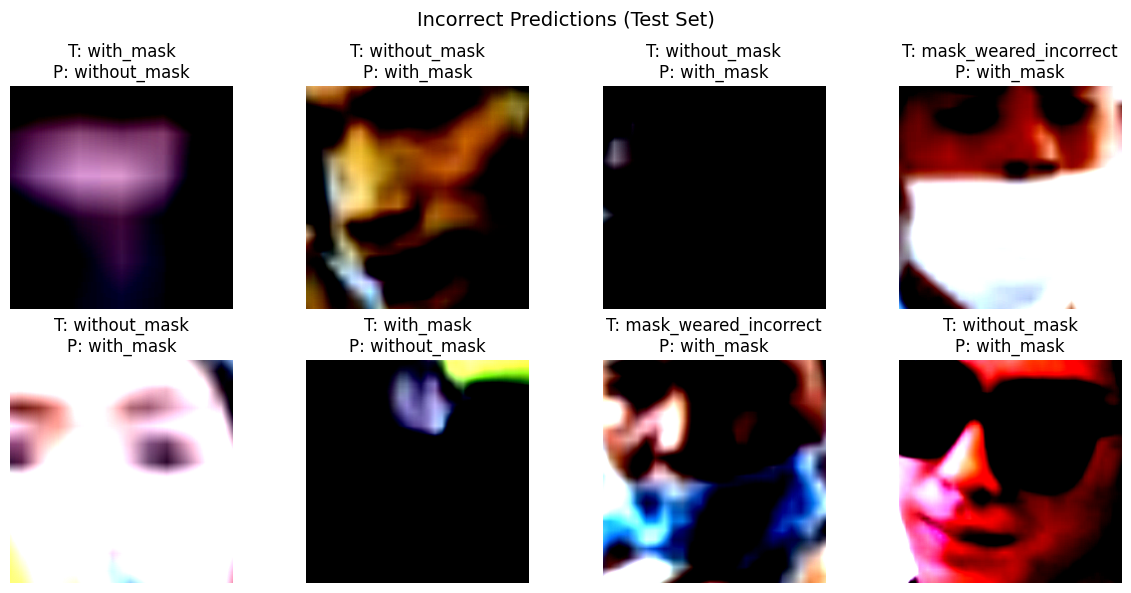

In [41]:
# Visualise some incorrect predictions
import matplotlib.pyplot as plt
import random

n_show = 8
samples = random.sample(incorrect, min(n_show, len(incorrect)))

plt.figure(figsize=(12, 6))

for i, sample in enumerate(samples):
    img = sample["image"].permute(1, 2, 0)
    true_label = class_names[sample["true"]]
    pred_label = class_names[sample["pred"]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f"T: {true_label}\nP: {pred_label}")
    plt.axis("off")

plt.suptitle("Incorrect Predictions (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()

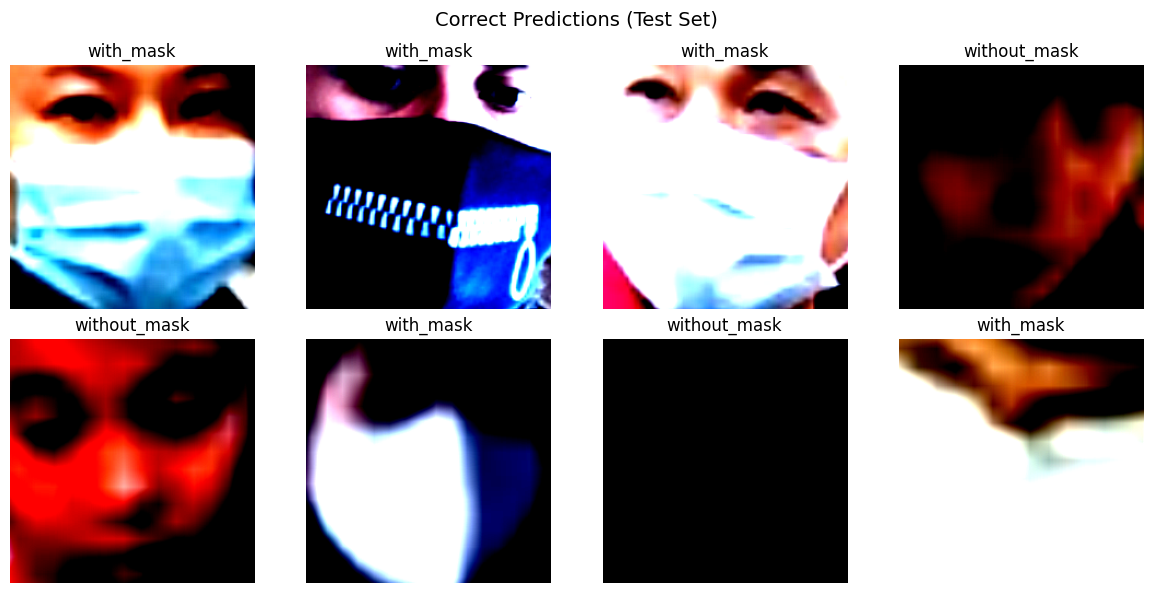

In [42]:
# Visualise some correct predictions
samples = random.sample(correct, n_show)

plt.figure(figsize=(12, 6))

for i, sample in enumerate(samples):
    img = sample["image"].permute(1, 2, 0)
    label = class_names[sample["true"]]

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.suptitle("Correct Predictions (Test Set)", fontsize=14)
plt.tight_layout()
plt.show()